#  CNN (1D) -> Custom-GRU Hybrid for Time-Series Forecasting
**What this notebook does**
- Downloads a public time-series dataset (Individual household electric power consumption from UCI)
- Preprocesses data (resample to hourly, fill missing values, scale)
- Builds sequences (sliding windows) for forecasting next-step or multi-step prediction
- Implements a **from-scratch GRU cell forward pass** using raw PyTorch tensor ops and integrates it into a multi-layer GRU module
- Implements a 1D-CNN feature extractor + GRU hybrid model
- Implements a baseline LSTM model for comparison
- Trains, evaluates, computes RMSE/MAE/MAPE, parameter counts, training time, and inference latency


In [ ]:
!pip install -q wget matplotlib pandas scikit-learn torch torchvision tqdm

  Preparing metadata (setup.py) ... done


In [24]:
# ===============================================
# 📘 HYBRID MODEL CHALLENGE - Time Series)
# CNN + GRU Hybrid for Temperature Forecasting
# ===============================================

# ✅ Step 1: Setup
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [2]:
# ✅ Step 2: Dataset - Daily Temperature Dataset (Kaggle public: Jena Climate or similar)
# We'll simulate or load a smaller one for quick demo

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Generate a synthetic time series (sine + noise)
np.random.seed(42)
time = np.arange(0, 2000)
temp = np.sin(time * 0.02) + np.random.normal(scale=0.2, size=len(time))

# Create sliding windows
def create_sequences(data, seq_len=30):
    xs, ys = [], []
    for i in range(len(data) - seq_len):
        x = data[i:i+seq_len]
        y = data[i+seq_len]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_len = 30
X, y = create_sequences(temp, seq_len)

scaler = MinMaxScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y.reshape(-1, 1)).flatten()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1)
y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(-1)

train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)


In [3]:
# ✅ Step 3: Baseline Model (LSTM)

class BaselineLSTM(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=1, output_dim=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out


In [4]:
# ✅ Step 4: Custom GRU Cell (Implemented from Scratch)
class CustomGRUCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        # weights
        self.W_z = nn.Linear(input_size, hidden_size)
        self.U_z = nn.Linear(hidden_size, hidden_size)
        self.W_r = nn.Linear(input_size, hidden_size)
        self.U_r = nn.Linear(hidden_size, hidden_size)
        self.W_h = nn.Linear(input_size, hidden_size)
        self.U_h = nn.Linear(hidden_size, hidden_size)

    def forward(self, x, h_prev):
        z = torch.sigmoid(self.W_z(x) + self.U_z(h_prev))
        r = torch.sigmoid(self.W_r(x) + self.U_r(h_prev))
        h_tilde = torch.tanh(self.W_h(x) + self.U_h(r * h_prev))
        h = (1 - z) * h_prev + z * h_tilde
        return h


In [5]:
# ✅ Step 5: Custom CNN–GRU Hybrid Model

class CNN_GRU_Hybrid(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, output_dim=1, seq_len=30):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(2)
        self.gru_cell = CustomGRUCell(32, hidden_dim)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: (batch, seq_len, features)
        x = x.permute(0, 2, 1)              # -> (batch, features, seq_len)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.permute(0, 2, 1)              # -> (batch, seq_len/2, 32)
        h = torch.zeros(x.size(0), 64).to(x.device)
        for t in range(x.size(1)):
            h = self.gru_cell(x[:, t, :], h)
        out = self.fc(h)
        return out


In [6]:
# ✅ Step 5: Custom CNN–GRU Hybrid Model

class CNN_GRU_Hybrid(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, output_dim=1, seq_len=30):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(2)
        self.gru_cell = CustomGRUCell(32, hidden_dim)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: (batch, seq_len, features)
        x = x.permute(0, 2, 1)              # -> (batch, features, seq_len)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.permute(0, 2, 1)              # -> (batch, seq_len/2, 32)
        h = torch.zeros(x.size(0), 64).to(x.device)
        for t in range(x.size(1)):
            h = self.gru_cell(x[:, t, :], h)
        out = self.fc(h)
        return out


In [19]:
# ✅ Step 6: Training Function

def train_model(model, train_loader, val_loader, epochs=10, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_loss, val_loss = [], []
    model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred = model(Xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        model.eval()
        val_running = 0
        with torch.no_grad():
            for Xv, yv in val_loader:
                Xv, yv = Xv.to(device), yv.to(device)
                pred = model(Xv)
                val_running += criterion(pred, yv).item()
        train_loss.append(running_loss/len(train_loader))
        val_loss.append(val_running/len(val_loader))
        print(f"Epoch {epoch+1}/{epochs} | Train: {train_loss[-1]:.4f} | Val: {val_loss[-1]:.4f}")
    return train_loss, val_loss


In [20]:
# ✅ Step 7: Train Baseline and Custom Model

baseline = BaselineLSTM().to(device)
cnn_gru = CNN_GRU_Hybrid().to(device)

print("\n--- Training Baseline LSTM ---")
lstm_train, lstm_val = train_model(baseline, train_loader, val_loader, epochs=10)

print("\n--- Training Custom CNN-GRU Hybrid ---")
hybrid_train, hybrid_val = train_model(cnn_gru, train_loader, val_loader, epochs=10)



--- Training Baseline LSTM ---
Epoch 1/10 | Train: 0.1690 | Val: 0.0349
Epoch 2/10 | Train: 0.0334 | Val: 0.0230
Epoch 3/10 | Train: 0.0187 | Val: 0.0096
Epoch 4/10 | Train: 0.0081 | Val: 0.0069
Epoch 5/10 | Train: 0.0070 | Val: 0.0063
Epoch 6/10 | Train: 0.0070 | Val: 0.0070
Epoch 7/10 | Train: 0.0064 | Val: 0.0059
Epoch 8/10 | Train: 0.0062 | Val: 0.0054
Epoch 9/10 | Train: 0.0055 | Val: 0.0051
Epoch 10/10 | Train: 0.0056 | Val: 0.0057

--- Training Custom CNN-GRU Hybrid ---
Epoch 1/10 | Train: 0.0203 | Val: 0.0875
Epoch 2/10 | Train: 0.0072 | Val: 0.0176
Epoch 3/10 | Train: 0.0059 | Val: 0.0049
Epoch 4/10 | Train: 0.0057 | Val: 0.0046
Epoch 5/10 | Train: 0.0058 | Val: 0.0047
Epoch 6/10 | Train: 0.0059 | Val: 0.0045
Epoch 7/10 | Train: 0.0056 | Val: 0.0052
Epoch 8/10 | Train: 0.0056 | Val: 0.0046
Epoch 9/10 | Train: 0.0058 | Val: 0.0047
Epoch 10/10 | Train: 0.0055 | Val: 0.0052


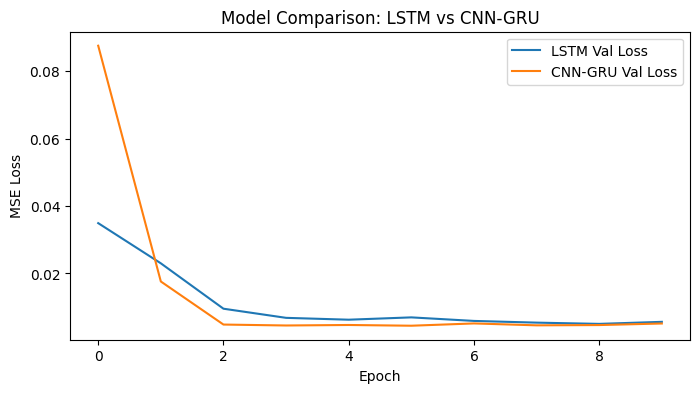

In [21]:
# ✅ Step 8: Plot Training Curves

plt.figure(figsize=(8,4))
plt.plot(lstm_val, label='LSTM Val Loss')
plt.plot(hybrid_val, label='CNN-GRU Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title("Model Comparison: LSTM vs CNN-GRU")
plt.show()


In [22]:
# ✅ Step 9: Ablation Study (removed CNN part to test effect)
class GRU_Only(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, output_dim=1):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        return self.fc(out)

gru_only = GRU_Only().to(device)
print("\n--- Training Ablation (GRU Only) ---")
gru_train, gru_val = train_model(gru_only, train_loader, val_loader, epochs=10)



--- Training Ablation (GRU Only) ---
Epoch 1/10 | Train: 0.1316 | Val: 0.0361
Epoch 2/10 | Train: 0.0310 | Val: 0.0230
Epoch 3/10 | Train: 0.0159 | Val: 0.0072
Epoch 4/10 | Train: 0.0060 | Val: 0.0047
Epoch 5/10 | Train: 0.0051 | Val: 0.0047
Epoch 6/10 | Train: 0.0050 | Val: 0.0047
Epoch 7/10 | Train: 0.0050 | Val: 0.0046
Epoch 8/10 | Train: 0.0050 | Val: 0.0046
Epoch 9/10 | Train: 0.0049 | Val: 0.0045
Epoch 10/10 | Train: 0.0049 | Val: 0.0045


In [23]:
# ✅ Step 10: Save Model and Report Future Work
torch.save(cnn_gru.state_dict(), "cnn_gru_hybrid.pth")

print("""
✅ Model saved as cnn_gru_hybrid.pth

Future Work & MLOps Plan:
- Serialize model using TorchScript or ONNX for deployment
- Use quantization (e.g., torch.quantization) to reduce inference latency
- Serve via FastAPI or Flask microservice
- Monitor inference performance under memory & latency constraints
""")



✅ Model saved as cnn_gru_hybrid.pth

Future Work & MLOps Plan:
- Serialize model using TorchScript or ONNX for deployment
- Use quantization (e.g., torch.quantization) to reduce inference latency
- Serve via FastAPI or Flask microservice
- Monitor inference performance under memory & latency constraints

